<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/fastai/Weights_&_Biases_with_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--- @wandbcode{fastai-wandb} -->

<img src="https://i.imgur.com/pNKgZgL.png" alt="Fastai2 and Weights & Biases" width="400"/>

<!--- @wandbcode{fastai-wandb} -->

<div><img /></div>

<img src="https://i.imgur.com/uEtWSEb.png" width="650" alt="Weights & Biases" />

<div><img /></div>

# 💨 Fastai and 🏋️‍♀️ Weights & Biases

Fastai let us create quickly neural networks architectures using modern best practices in just a few lines of code.

This notebook shows how to use fastai with the[`WandbCallback`](https://docs.wandb.com/library/integrations/fastai) to log and visualize experiments.

## Install libraries

First, install and import `fastai` and `wandb`.

In [ ]:
!pip install -qU wandb fastai

In [ ]:
import wandb

from fastai.vision.all import *
from fastai.callback.wandb import *

## Log in to W&B
Log in so your results can stream to a private project in W&B. Here's more info on the [data privacy and export features](https://docs.wandb.com/company/data-and-privacy) you can use so W&B can serve as a reliable system of record for your experiments.

*Note: Login only needs to be done once, and it is automatically called with `wandb.init()`.*

In [ ]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


True

## Getting Started

Let's start with a very simple fastai pipeline:

In [ ]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.167861,0.047716,0.014208,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.056580,0.025385,0.008119,00:14


## How do we add W&B to this pipeline?
You just need to add the `WandbCallback` to the `Learner`

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate, cbs = WandbCallback())

create a run by calling `wandb.init`

In [ ]:
wandb.init(project="fastai");

Train your model as usual

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.146514,0.046027,0.012855,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.062179,0.028113,0.009472,00:15


end the run

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▁
lr_0,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇████▂▂▃▃▄▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁
lr_2,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇████▂▂▃▃▄▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁
mom_0,████▇▇▆▆▆▅▄▄▃▃▂▂▂▁▁▁█▇▆▄▂▁▁▁▂▂▃▃▄▅▆▆▇███
mom_1,████▇▇▆▆▆▅▄▄▃▃▂▂▂▁▁▁█▇▆▄▂▁▁▁▂▂▃▃▄▅▆▆▇███
mom_2,████▇▇▆▆▆▅▄▄▃▃▂▂▂▁▁▁█▇▆▄▂▁▁▁▂▂▃▃▄▅▆▆▇███


you can now click on the run link and enjoy your dashboard ☝️

**TLDR**; it's even shorter if you use the context manager:
```python
with wandb.init(project="fastai"):
    learn = vision_learner(dls, resnet34, metrics=error_rate, cbs = WandbCallback())
    learn.fine_tune(1)
```

## Semantic segmentation on CamVid

In this example, we'll train a U-Net with a ResNet encoder to perform semantic segmentation on the CamVid dataset.

<img src="http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/pr/DBOverview1_1_huff_0000964.jpg" alt="Camvid dataset" width="500"/>

### Download the dataset

Fastai datasets are downloaded from a URL and cached locally.

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path

Path('/home/tcapelle/.fastai/data/camvid_tiny')

This specific dataset contains:
* a folder of input images
* a folder of segmentation masks (same name as images with added suffix `_P`)
* a file listing in order the possible classes
* a file listing which files belong to validation set

### Create DataLoaders
We can create `DataLoaders` in many possible ways: from a `Dataset`, `TfmdList`, `DataBlock` or custom methods such as `ImageDataLoaders` or `SegmentationDataLoaders`.

In [ ]:
# Get classes
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
# Get list of input files path
fnames = get_image_files(path/"images")
fnames[:3]

(#3) [Path('/home/tcapelle/.fastai/data/camvid_tiny/images/0016E5_08400.png'),Path('/home/tcapelle/.fastai/data/camvid_tiny/images/0016E5_08370.png'),Path('/home/tcapelle/.fastai/data/camvid_tiny/images/0001TP_010200.png')]

In [ ]:
# get label path from an input path
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [ ]:
# create DataLoaders using a function specific to semantic segmentation
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames=fnames, label_func=label_func, codes=codes)

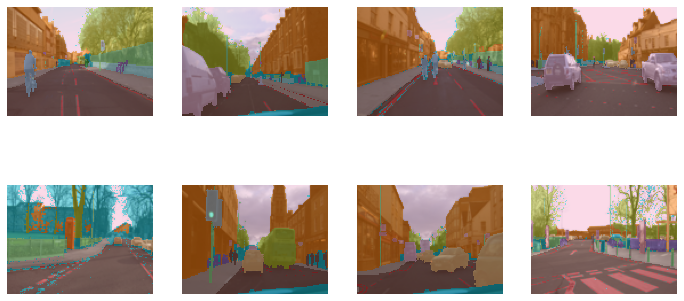

In [ ]:
dls.show_batch()

### Train a model

We start a new W&B run with wandb.init() which gives us a link to our logged run.

In [ ]:
wandb.init(project='fastai');

`WandbCallback` can automatically track:
* hyper-parameters
* losses & metrics
* models
* datasets
* code
* computer resources

In addition to logging losses & metrics, we are going to log our dataset and our model, which will be automatically versioned.

In [ ]:
learn = unet_learner(dls, resnet18, metrics=foreground_acc, cbs=WandbCallback(log_dataset=True, log_model=True))

In [ ]:
learn.fit_one_cycle(5)

wandb: Adding directory to artifact (/home/tcapelle/.fastai/data/camvid_tiny/images)... Done. 0.0s
wandb: Adding directory to artifact (/home/tcapelle/.fastai/data/camvid_tiny/labels)... Done. 0.0s


epoch,train_loss,valid_loss,foreground_acc,time
0,2.789380,2.083295,0.432363,00:02
1,2.243412,1.459005,0.598270,00:02
2,1.856881,1.230638,0.658329,00:02
3,1.612155,1.127360,0.677341,00:02
4,1.445099,1.096314,0.682663,00:02


Better model found at epoch 0 with valid_loss value: 2.0832951068878174.
Better model found at epoch 1 with valid_loss value: 1.459004521369934.
Better model found at epoch 2 with valid_loss value: 1.2306379079818726.
Better model found at epoch 3 with valid_loss value: 1.127360463142395.
Better model found at epoch 4 with valid_loss value: 1.0963139533996582.


In [ ]:
# optional: mark the run as completed
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,▁▆▇██
lr_0,▁▁▂▃▄▅▆▁▂▃▄▅▆▇█████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁
lr_1,▁▁▂▃▄▅▆▁▂▃▄▅▆▇█████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁
lr_2,▁▁▂▃▄▅▆▁▂▃▄▅▆▇█████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁
mom_0,███▆▆▄▃██▆▆▄▃▂▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇████
mom_1,███▆▆▄▃██▆▆▄▃▂▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇████
mom_2,███▆▆▄▃██▆▆▄▃▂▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇████


That's it! Check out your fastai model training in the live W&B dashboard by clicking on the link printed out above.

# Example W&B dashboard
![](https://i.imgur.com/jef6GjA.png)



# Learn more!
1. [Documentation](https://docs.wandb.com/library/integrations/fastai): Explore the docs to learn what's possible with Weights & Biases visualizations for Fastai models
2. [Slack community](http://wandb.me/slack): Ask questions and share results in our vibrant community of practitioners
3. [Gallery](app.wandb.ai/gallery): See more reproducible research projects from practitioners around the world in the W&B gallery

